**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we build the parameter grids based on quantiles of the distributions of the tuning parameters. For every service and parameter we use a maximum of 20 parameter values as a default. (Note that depending on the distribution the number of the resulting parameter values can be less than 20.) For this step we consider only those responses where the API/service decided for 'f' or 'm' (so we ignore 'unknown' or similar). 

Finally, we train each evaluator on the entire data set to obtain the best parameter values for a given error.

In [1]:
import pandas as pd
import numpy as np
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS, compute_equal_frequency_binning

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['style', 'shuffle']
`%matplotlib` prevents i

## Compute errors without tuning

In [2]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error','f_precision', 'f_recall']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [3]:
compute_all_errors_without_tuning()

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error,f_precision,f_recall
gender_guesser,0.229361,0.035243,0.005405,0.201209,0.081515,0.941360,0.956274
names_api,0.237997,0.050161,0.010549,0.197755,0.094789,0.918308,0.945140
gender_api,0.086701,0.058405,-0.008191,0.030052,0.064203,0.924559,0.902350
namsor,0.135924,0.051384,0.010049,0.089119,0.069590,0.911184,0.938453
genderize_io,0.150432,0.058925,0.025253,0.097237,0.078770,0.886715,0.951381
names_api_full,0.186874,0.043284,0.007112,0.150086,0.075921,0.927865,0.947150
gender_api_full,0.204145,0.077108,-0.019027,0.137651,0.105659,0.911043,0.860870


## Discretize distribution of tuning parameters

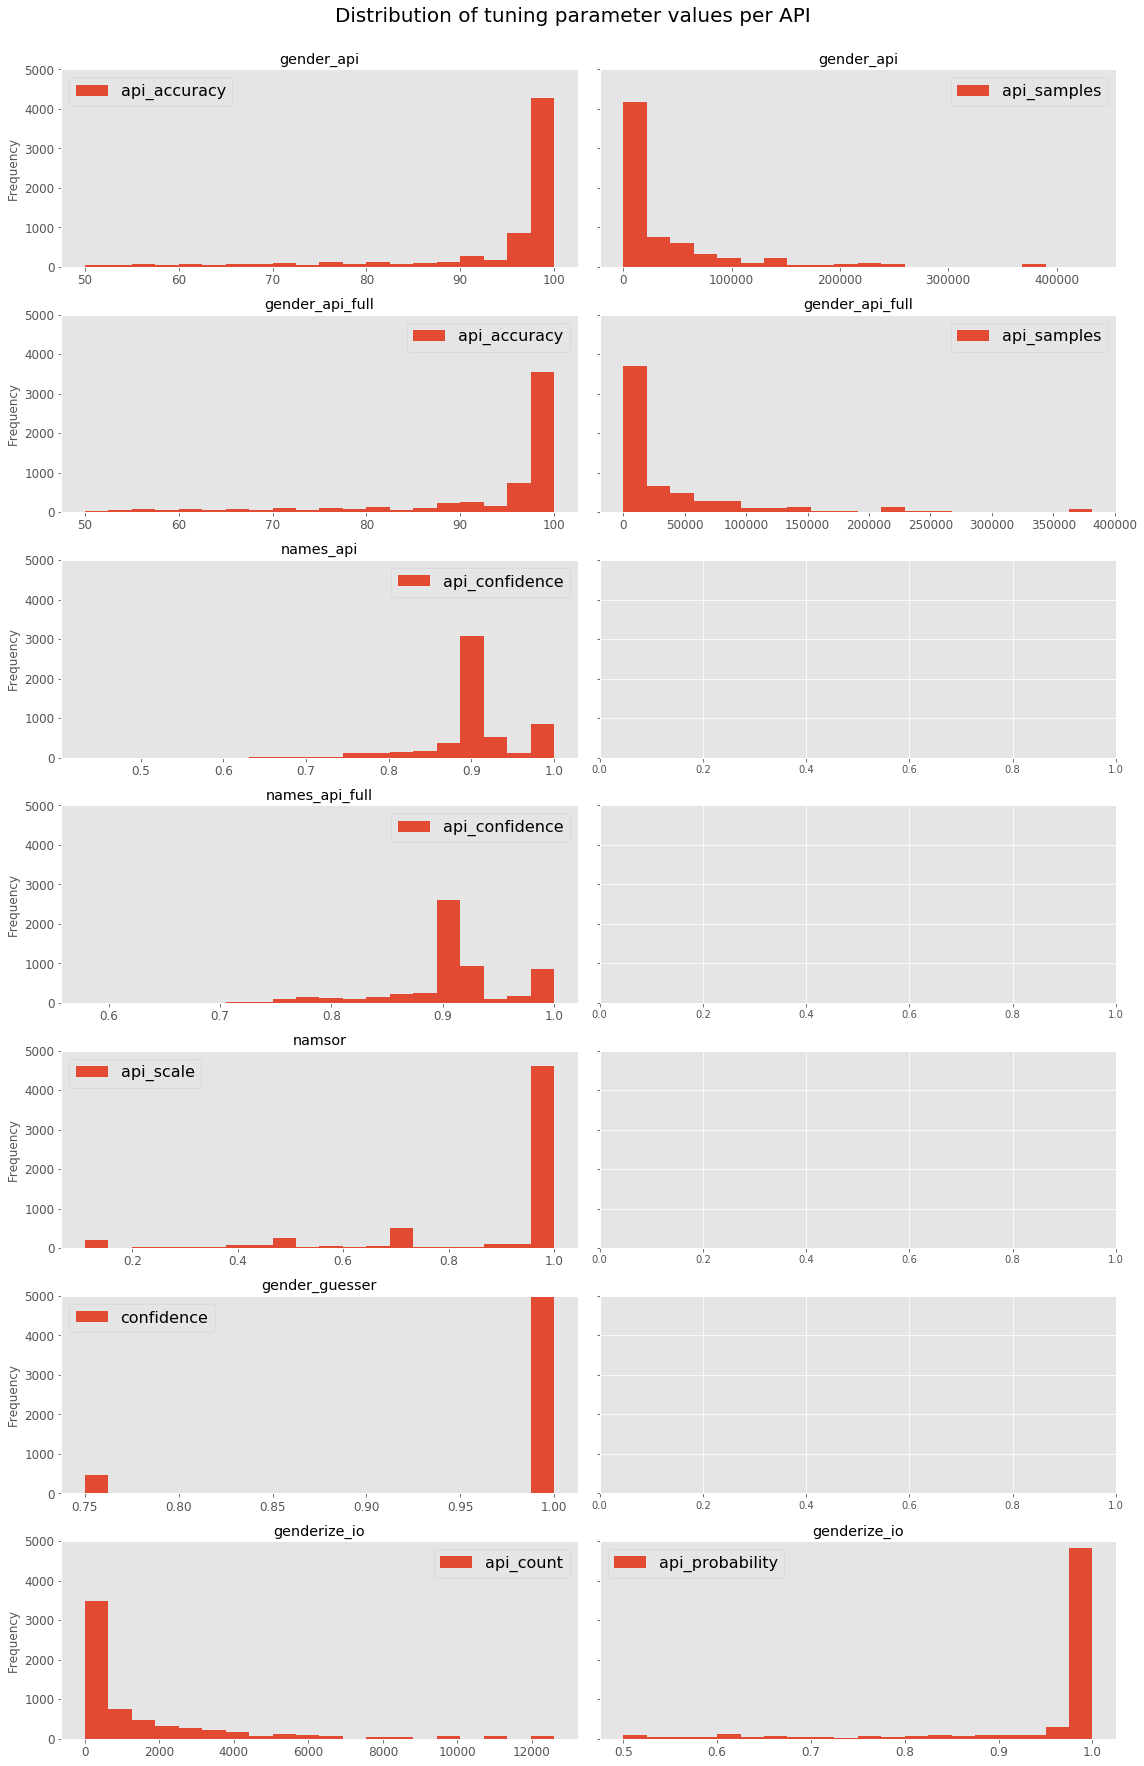

In [4]:
rows = len(REGISTERED_EVALUATORS)
cols = 2
fs=12
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 24))
#cmap = plt.get_cmap('YlGnBu')

formatter = FuncFormatter(lambda v, pos: str(v * 100)) # from: https://github.com/matplotlib/matplotlib/issues/320/

for i, s in enumerate(REGISTERED_EVALUATORS):    
    evaluator = s('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
    for j, param in enumerate(list(evaluator.tuning_params)):
        evaluator.test_data[[param]].plot(ax=axes[i][j], kind='hist', stacked=False, title=s.gender_evaluator, 
                                         sharey=True, fontsize=fs, grid=False, bins=20, ylim=(0, 5000) #, normed=True
                                         )
        
        axes[i][j].legend(loc='best', fontsize=fs+4)
        #axes[i][j].yaxis.set_major_formatter(formatter)
        #axes[i][j].set_ylabel('')

plt.suptitle('Distribution of tuning parameter values per API', fontsize=20, y=1.02)

fig.tight_layout()

### Use quantiles

In [5]:
# test on genderize_io
evaluator = REGISTERED_EVALUATORS[-1]('all')
tuning_param = 'api_probability'

In [6]:
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

data = evaluator.test_data[tuning_param]
# add bins to df to check whether param_value lies in interval
evaluator.test_data['api_bins'] = pd.qcut(data, 5, duplicates='drop')

In [7]:
evaluator.test_data.head()

,index,first_name,middle_name,last_name,full_name,gender,origin,api_count,api_gender,api_name,api_probability,gender_infered,api_bins
0,0,pierre,paul,grivel,pierre paul grivel,m,zbmath,5.0,male,pierre-paul,1.00,m,"(0.99, 1.0]"
1,1,raul,,serapioni,raul serapioni,m,zbmath,821.0,male,raul,1.00,m,"(0.99, 1.0]"
2,2,adriano,,moura,adriano moura,m,zbmath,166.0,male,adriano,0.99,m,"(0.95, 0.99]"
3,3,ralf,,kieser,ralf kieser,m,zbmath,86.0,male,ralf,1.00,m,"(0.99, 1.0]"
4,5,guillermo,,leon-de-la-barra,guillermo leon-de-la-barra,m,zbmath,850.0,male,guillermo,1.00,m,"(0.99, 1.0]"


In [8]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 5)

[0, 0.499, 0.94999999999999996, 0.98999999999999999]

In [9]:
compute_equal_frequency_binning(evaluator.test_data[tuning_param], 20)

[0,
 0.499,
 0.60999999999999999,
 0.76000000000000001,
 0.88,
 0.94999999999999996,
 0.97999999999999998,
 0.98999999999999999]

## Build parameter grids for all services

Example from scikit-learn docstring

In [10]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
import numpy as np
np.random.seed(0)
param_grid = {'a':[1, 2], 'b': expon()}
param_list = list(ParameterSampler(param_grid, n_iter=4))
rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]

rounded_list

[{'a': 1, 'b': 0.89856000000000003},
 {'a': 1, 'b': 0.92322300000000002},
 {'a': 2, 'b': 1.8789640000000001},
 {'a': 2, 'b': 1.0381590000000001}]

In [11]:
# Do the same for our context
def sample_params_from_distribution(e, n_iter=20):
    param_grid = {}
    for param in list(e.tuning_params):
        param_grid[param] = e.test_data[param].values
    
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter**len(e.tuning_params)))
    rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]
    
    return rounded_list

In [12]:
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

sample_params_from_distribution(evaluator, n_iter=3)

[{'api_accuracy': 99, 'api_samples': 9249},
 {'api_accuracy': 98, 'api_samples': 8496},
 {'api_accuracy': 97, 'api_samples': 23277},
 {'api_accuracy': 98, 'api_samples': 131879},
 {'api_accuracy': 81, 'api_samples': 3281},
 {'api_accuracy': 51, 'api_samples': 16800},
 {'api_accuracy': 65, 'api_samples': 38223},
 {'api_accuracy': 99, 'api_samples': 5178},
 {'api_accuracy': 95, 'api_samples': 2917}]

In [13]:
def build_grid_for_all_services(max_grid_points):
    service_to_grid_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_data_for_parameter_tuning()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_grid_range[evaluator.gender_evaluator] = sample_params_from_distribution(evaluator)
            
        #grid_range = [compute_equal_frequency_binning(evaluator.test_data[param], max_grid_points) 
        #              for param in list(evaluator.tuning_params)]
        #service_to_grid_range[evaluator.gender_evaluator] = grid_range
        
    return service_to_grid_range

In [47]:
def check_density_of_grids(grids):
    # check how many parameter values we have per service
    for k,v in grids.items():
        print("Service name:", k)
        for i, param_range in enumerate(v):
            print(str(i+1) + ". tuning parameter:", len(param_range))

In [14]:
grid_30 = build_grid_for_all_services(30)
grid_20 = build_grid_for_all_services(20)

In [17]:
grid_20['gender_api']

[{'api_accuracy': 91, 'api_samples': 11557},
 {'api_accuracy': 99, 'api_samples': 12224},
 {'api_accuracy': 89, 'api_samples': 5646},
 {'api_accuracy': 99, 'api_samples': 9099},
 {'api_accuracy': 99, 'api_samples': 339},
 {'api_accuracy': 56, 'api_samples': 1175},
 {'api_accuracy': 98, 'api_samples': 145540},
 {'api_accuracy': 98, 'api_samples': 4712},
 {'api_accuracy': 99, 'api_samples': 513},
 {'api_accuracy': 94, 'api_samples': 219085},
 {'api_accuracy': 81, 'api_samples': 1687},
 {'api_accuracy': 98, 'api_samples': 1290},
 {'api_accuracy': 98, 'api_samples': 29790},
 {'api_accuracy': 76, 'api_samples': 2954},
 {'api_accuracy': 100, 'api_samples': 9994},
 {'api_accuracy': 99, 'api_samples': 247084},
 {'api_accuracy': 97, 'api_samples': 8},
 {'api_accuracy': 99, 'api_samples': 97659},
 {'api_accuracy': 100, 'api_samples': 77620},
 {'api_accuracy': 98, 'api_samples': 88317},
 {'api_accuracy': 99, 'api_samples': 97659},
 {'api_accuracy': 100, 'api_samples': 381770},
 {'api_accuracy': 1

In [21]:
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [23]:
df = pd.DataFrame.from_dict(grid_20['gender_api'])

In [25]:
df.head()

,api_accuracy,api_samples
0,91,11557
1,99,12224
2,89,5646
3,99,9099
4,99,339


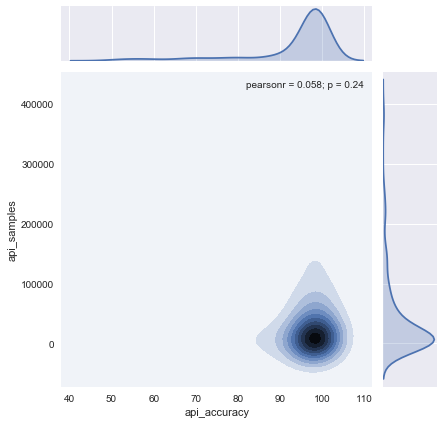

In [27]:
sns.jointplot(x="api_accuracy", y="api_samples", data=df, kind="kde");

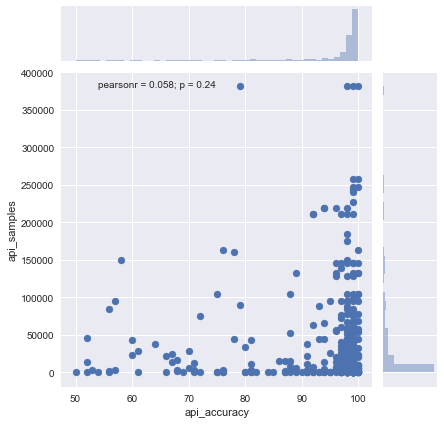

In [29]:
sns.jointplot(x="api_accuracy", y="api_samples", data=df);

## Benchmark (with `grid_20`)

In [18]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_data_for_parameter_tuning()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, grids, constraint_func=None, constraint_val=None):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        #grid_range = grids[evaluator_name]
        #grid = evaluator.build_parameter_grid(*grid_range)
        grid = grids[evaluator_name]
        mean_test_error = evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

## Errors from `genderizeR` paper

In [19]:
error_with_unknown = tune(Evaluator.compute_error_with_unknown, grid_20)

gender_api
minimal train error: 0.0870222414165 corresponding test error: 0.0854184641933
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0870034542314 corresponding test error: 0.0854922279793
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0865716753022 corresponding test error: 0.087219343696
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
minimal train error: 0.0861398963731 corresponding test error: 0.0898100172712
params for lowest train error: {'api_accuracy': 54, 'api_samples': 41}
minimal train error: 0.0867688322901 corresponding test error: 0.0864304235091
params for lowest train error: {'api_accuracy': 52, 'api_samples': 15}
Average test error: 0.0868740953298
gender_api_full
minimal train error: 0.204059598359 corresponding test error: 0.204486626402
params for lowest train error: {'api_accuracy': 53, 'api_samples': 8}
minimal train error: 0.20207253886 corres

**Best result is achieved by `gender_api` with an average test error 0.0867013837581. Second best is `namsor` with 0.135923449219. All services achieve their best result at or near the left boundary of the parameter grid.**

In [18]:
error_without_unknown = tune(Evaluator.compute_error_without_unknown, grid_20)

gender_api
minimal train error: 0.0081053698075 corresponding test error: 0.00980392156863
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.0095525389643 corresponding test error: 0.0040404040404
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00800800800801 corresponding test error: 0.0102880658436
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00847457627119 corresponding test error: 0.00836820083682
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
minimal train error: 0.00812595226003 corresponding test error: 0.00970873786408
params for lowest train error: {'api_accuracy': 99.0, 'api_samples': 179732.75}
Average test error: 0.00844186603071
gender_api_full
minimal train error: 0.0158615717376 corresponding test error: 0.0193637621024
params for lowest train error: {'api_accuracy': 97.0, 'a

**Best result is achieved by `gender_api` with an average test error 0.00844186603071. Second best is `namsor` with 0.0166385626826. Several other services follow with very low errors as well. All services achieve their best result at or near the right boundary of the parameter grid.**

In [19]:
error_unknown = tune(Evaluator.compute_error_unknown, grid_20)

gender_api
minimal train error: 0.0291513711941 corresponding test error: 0.0336496980155
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0300086355786 corresponding test error: 0.0302245250432
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304404145078 corresponding test error: 0.0284974093264
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0302245250432 corresponding test error: 0.0293609671848
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
minimal train error: 0.0304338441615 corresponding test error: 0.028522039758
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 0}
Average test error: 0.0300509278656
gender_api_full
minimal train error: 0.136687540488 corresponding test error: 0.141501294219
params for lowest train error: {'api_accuracy': 0, 'api_samples': 5041.0}
minimal train error: 0.134283246

**Best result is achieved by `gender_api` with an average test error 0.0300509278656. Second best is `namsor` with 0.0891206876941. All services achieve their best result at or near the left boundary of the parameter grid.**

## Weighted error

This is a version of `error_with_unknown` where we put a weight of 0.2 on the names with true gender being 'f' or 'm' but classified as 'unknown'.

In [21]:
weighted_error = tune(Evaluator.compute_weighted_error, grid_20)

gender_api
minimal train error: 0.0526142096082 corresponding test error: 0.0514200853908
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532586174421 corresponding test error: 0.0488623647893
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0512471867967 corresponding test error: 0.0569259962049
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0515299418059 corresponding test error: 0.0557655954631
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
minimal train error: 0.0532169505843 corresponding test error: 0.048969559463
params for lowest train error: {'api_accuracy': 75.0, 'api_samples': 121922.0}
Average test error: 0.0523887202622
gender_api_full
minimal train error: 0.0958408679928 corresponding test error: 0.0950639853748
params for lowest train error: {'api_accuracy': 72.0, 'api_samples': 

**Best result is achieved by `gender_api` with an average test error 0.0523887202622. Second best is `namsor` with 0.0640116391787. Several other services follow with very low errors as well.** 


## Minimize `error_with_unknown` with a constraint on the maximal value of `error_without_unknown`

In [22]:
constraint_error = tune(error_func=Evaluator.compute_error_with_unknown, grids=grid_20, 
                      constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05)

gender_api
minimal train error: 0.0902612826603 corresponding test error: 0.0871440897325
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 82.0}
minimal train error: 0.0949913644214 corresponding test error: 0.0915371329879
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 1208.0}
minimal train error: 0.0993091537133 corresponding test error: 0.105354058722
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.0990932642487 corresponding test error: 0.10621761658
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 4788.0}
minimal train error: 0.102741204403 corresponding test error: 0.100259291271
params for lowest train error: {'api_accuracy': 64.0, 'api_samples': 10383.0}
Average test error: 0.0981024378586
gender_api_full
minimal train error: 0.256748002591 corresponding test error: 0.243313201035
params for lowest train error: {'api_accuracy': 81.0, 'api_samples': 3415.800000000000

**Best result is achieved by `gender_api` with an average test error 0.0981024378586. Second best is `namsor` with 0.154399563909.** 


---------------------

## TODO: Compute best parameter values for entire dataset

In [23]:
# TODO: fix this function. it should iterate through errors instead of evaluators. ANd return DataFrame.
def find_best_params_per_service(error_func, grids):
    service_to_error = {} # this is a stupid name but don't want to overwrite above
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)

        grid_range = grids[evaluator_name]
        grid = evaluator.build_parameter_grid(*grid_range)
        index = evaluator.test_data.index

        error = evaluator.compute_error_for_param_grid(param_grid=grid, error_func=error_func, index=index)
        service_to_error[evaluator_name] = error
    return service_to_error

## TODO: have a closer look into the wrong classifications